## Step 1: Let's Get Some Images

For the sake of practice I won't be using the API here and instead scraping from the game-level pages on plays.tv

In [63]:
import urllib
from bs4 import BeautifulSoup
import csv
import requests
import os
from IPython.display import clear_output
import numpy as np
import cv2
import math
import sklearn
from matplotlib import pyplot as plt
from PIL import Image
import random
%matplotlib inline

## Reusing some code from an earlier project to get images

This goes to the game page of plays.tv, and looks at a game index page - such as: https://plays.tv/game/CounterStrikeGlobalOffensive?game_id=04094bf1f162594b28707b50c4e8349e . It finds all 720 videos. We download the video, sample frames at once a seconds, and save the frames as 144 * 96 images

For the training itself we'll convert it into luminesence 

In [64]:
# Frames per Game
FRAME_LIMIT = 500

def downloadVideo(name, url):
    r=requests.get(url)
    f=open(name,'wb')
    for chunk in r.iter_content(chunk_size=255): 
        if chunk: 
            f.write(chunk)
    f.close()
    
base_urls = {
    "csgo" : "https://plays.tv/game/CounterStrikeGlobalOffensive?game_id=04094bf1f162594b28707b50c4e8349e&page={}",
    "gta5" : "https://plays.tv/game/GrandTheftAutoV?game_id=65514104855d11e3aebc655d44bec87b&page={}",
    "dota2" : "https://plays.tv/game/Dota2?game_id=e9af38482c77a80a0688bbcab98a933f&page={}",
    "rs6" : "https://plays.tv/game/TomClancysRainbowSixSiege?game_id=114cdf56f27611e3a930b04744bec87b&page={}",
    "pubg" : "https://plays.tv/game/PLAYERUNKNOWNSBATTLEGROUNDS?game_id=beab9bd40164e6ed6101d7e0914b59e1&page={}",
    "fortnite" : "https://plays.tv/game/Fortnite?game_id=98ff5053ea366a4965ba7dbcfa10670c&page={}",
    "league" : "https://plays.tv/game/LeagueofLegends?game_id=b179585c6b68a2791eea4a1ad3d7ef72&page={}",
    "overwatch" : "https://plays.tv/game/Overwatch?game_id=101652c2d97f9a8d8872e7450f7daae6&sort=sort_popular&page={}"
}

if not os.path.exists('./playstvclips'):
    os.mkdir('playstvclips')
if not os.path.exists('./playstvscreenshots'):
    os.mkdir('playstvscreenshots')

images = {}

for key in base_urls.keys():
    images[key] = []
    n = 0
    frames = 0
    all_urls = []
    base_url = base_urls[key]

    for pages in range(10):
        if frames >= FRAME_LIMIT:
            continue
            
        page = base_url.format(str(pages))
        page_data = urllib.request.urlopen(page)
        soup = BeautifulSoup(page_data, "html.parser")
        urls = soup.findAll('source', limit=200)

        for url in [url for url in urls if '720' in url['src']]:
            if frames >= FRAME_LIMIT:
                continue
            # Status Check
            n+=1
            clear_output(wait=True)
            print(key + ' ' + str(n))
            
            # For VideoCapture to work it needs to be on disk...
            this_url = url['src'].replace('//', 'http://')
            file_name = './playstvclips/'+key+str(n)+'.mp4'
            downloadVideo(file_name, this_url)
            
            # Take screesnhots
            vidcap = cv2.VideoCapture(file_name)
            
            success, image = vidcap.read()
            #print(success)
            count = 0
            while success and frames < FRAME_LIMIT:
                # One frame per second
                vidcap.set(cv2.CAP_PROP_POS_MSEC,(count*1000))
                #cv2.imwrite('./playstvscreenshots/video{}frame{}.jpg'.format(str(n), str(count)), image)
                images[key].append(cv2.resize(image,(144, 96)))
                success,image = vidcap.read()
                
                count += 1
                frames += 1
            
            
            


overwatch 11


## We should now have a dictionary keyed on game name with an array of images as the value

Let's check the first entries

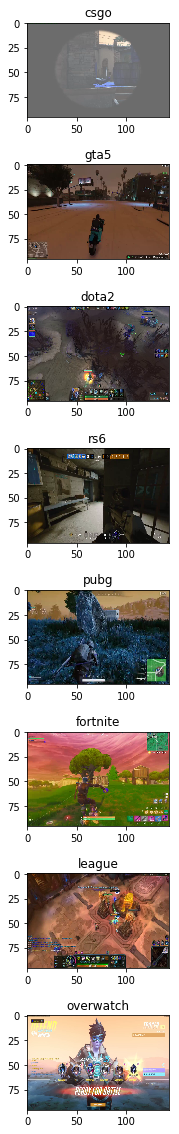

In [65]:
games = len(base_urls.keys())
fig = plt.figure(figsize=(games*50, 20))
fig.subplots_adjust(hspace=.5)
for idx, key in enumerate(base_urls.keys()):
    fig.add_subplot(games, 1, idx+1)
    plt.title(key)
    plt.imshow(images[key][0])

In [66]:
print("Check record counts")
for g in base_urls.keys():
    print("{} : {}".format(g, len(images[g])))

Check record counts
csgo : 500
gta5 : 500
dota2 : 500
rs6 : 500
pubg : 500
fortnite : 500
league : 500
overwatch : 500


## OK! ML Time.

For starters let's use Tensorflow's Keras API to train a multilayer network (conv2d->dense) and see how well it can differentiate these!


In [67]:
import tensorflow as tf
from tensorflow.keras import layers
print(tf.VERSION)
print(tf.keras.__version__)
from tensorflow.keras.models import *
from tensorflow.keras.layers import  *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import to_categorical


1.12.0
2.1.6-tf


In [68]:
print("We have {} games".format(games))

We have 8 games


In [69]:
# Simple Model
model = tf.keras.Sequential()
model.add(InputLayer(input_shape=[96, 144, 1]))
model.add(Conv2D(filters=32, kernel_size=5, strides=1, padding='same', 
                 activation='relu'))
model.add(MaxPool2D(pool_size=5,padding='same'))

model.add(Conv2D(filters=50, kernel_size=5, strides=1, padding='same', 
                 activation='relu'))
model.add(MaxPool2D(pool_size=5,padding='same'))

model.add(Conv2D(filters=80, kernel_size=5, strides=1, padding='same', 
                 activation='relu'))
model.add(MaxPool2D(pool_size=5,padding='same'))

model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(games,activation='softmax'))


model.compile(optimizer=tf.train.AdamOptimizer(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## We're going to transform the data

I could do this a bit more neatly and I could clean it up later. 

Additionally, we could save the images locally and do transforms with the keras utils. I'm not sure if this is worth doing as the game images should be dimensionally/rotationally static. 

In [70]:
def grey(images):
    return [np.asarray(Image.fromarray(i).convert('L')) for i in images]

base_data = []
base_labels = []

game_map = dict(zip(list(base_urls.keys()), range(games)))
game_map_inv = {v: k for k, v in game_map.items()}

for game in list(base_urls.keys()):
    base_data += images[game]
    base_labels += [game_map[game]] * len(images[game])
    
combined_random = list(zip(base_data, base_labels))
random.shuffle(combined_random)

base_train = combined_random[0:(int(len(combined_random)*4/5))]
base_test = combined_random[(int(len(combined_random)*4/5)):]

base_train_data = grey([i[0] for i in base_train])
base_train_labels = [i[1] for i in base_train]

base_test_data = grey([i[0] for i in base_test])
base_test_labels = [i[1] for i in base_test]                             
                                 
train_data = np.array(base_train_data).reshape(-1, 96, 144, 1)
train_labels = to_categorical(base_train_labels, num_classes=games)
test_data = np.array(base_test_data).reshape(-1, 96, 144, 1)
test_labels = to_categorical(base_test_labels, num_classes=games)

## Let's fit the model and evaluate it on some data we held out from training

In [71]:
model.fit(train_data, train_labels, epochs = 15, batch_size=64)

Epoch 1/15
3200/3200 [==============================] - 22s 7ms/step - loss: 9.8539 - acc: 0.1400
Epoch 2/15
3200/3200 [==============================] - 21s 7ms/step - loss: 1.7161 - acc: 0.3400
Epoch 3/15
3200/3200 [==============================] - 21s 7ms/step - loss: 0.9155 - acc: 0.6922
Epoch 4/15
3200/3200 [==============================] - 21s 7ms/step - loss: 0.3542 - acc: 0.8838
Epoch 5/15
3200/3200 [==============================] - 21s 7ms/step - loss: 0.2102 - acc: 0.9331
Epoch 6/15
3200/3200 [==============================] - 21s 7ms/step - loss: 0.1000 - acc: 0.9697
Epoch 7/15
3200/3200 [==============================] - 21s 7ms/step - loss: 0.0967 - acc: 0.9697
Epoch 8/15
3200/3200 [==============================] - 21s 7ms/step - loss: 0.0653 - acc: 0.9794
Epoch 9/15
3200/3200 [==============================] - 21s 7ms/step - loss: 0.0551 - acc: 0.9803
Epoch 10/15
3200/3200 [==============================] - 21s 7ms/step - loss: 0.0416 - acc: 0.9894
Epoch 11/15
3200/32

In [72]:
outputs = model.evaluate(test_data, test_labels, batch_size=32)
outputs = list(zip(model.metrics_names, outputs))
for o in outputs:
    print("{} : {}".format(o[0], o[1]))

800/800 [==============================] - 2s 2ms/step
loss : 0.03293473494122736
acc : 0.98875


## Let's look at some test examples

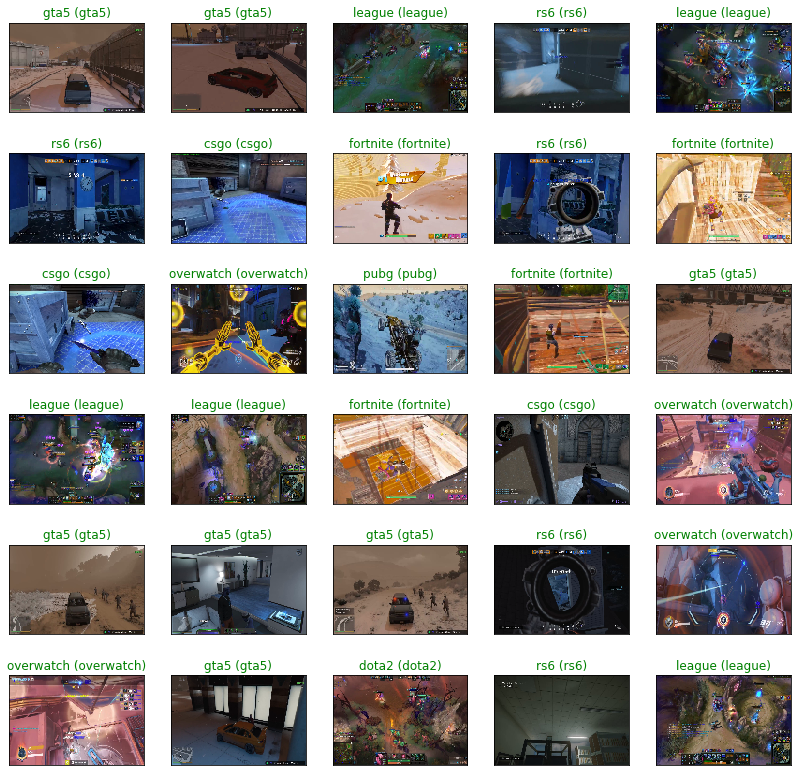

In [73]:
classes = model.predict(test_data, batch_size=32)
fig = plt.figure(figsize=(14,14))
for i in range(30):
    image = base_test[i][0]
    this_class = game_map_inv[np.argmax(classes[i])]
    subplot = fig.add_subplot(6, 5, i+1)
    subplot.imshow(image)
    title_color = 'red'
    if (this_class == game_map_inv[base_test[i][1]]):
        title_color = 'green'
    title = plt.title(this_class + ' ({})'.format(game_map_inv[base_test[i][1]]))
    plt.setp(title, color=title_color)
    subplot.get_yaxis().set_visible(False)
    subplot.get_xaxis().set_visible(False)
    